## A Taxonomy of TN Legislation

Using NLP, I look to answer the question: **What (state) legislation should I pay attention to?**

This might include legislation that:

- pertains to local issues in the city/town/county where I live
- pertains to issues I care about (e.g.: education)
- is introduced by my Representative/Senator
- is contentious (comes down to a close or party line vote)

and might not include legislation that:

- is uncontroversial (e.g., probably going to pass unanimously)
- has no chance of passing

Of course, these categories aren't mutually exclusive. I tag legislation meeting each characteristic individually so that we might look at bills meeting any combination of these criteria.

In [1]:
# Preliminaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_colwidth = 1000

Data comes from [OpenStates](https://openstates.org/), which provides comprehensive information pertaining to state legislators and legislation for all 50 states, DC and Puerto Rico, including bill text, topics, sponsors, progress through committees, amendments, vote tallies and votes by individual legislators.

OpenStates makes data available via an API, which I access using the [pyopenstates](http://docs.openstates.org/en/latest/api/) module.

In [2]:
sponsors = pd.read_csv("../data/tn_bill_sponsors.csv") \
    .groupby(['session', 'bill_id']) \
    .agg({'name': lambda x: '|'.join(x)}) \
    .rename(columns={'name': 'sponsors'}) \
    .reset_index()

bills = pd.read_csv('../data/tn_bills.csv') \
    .query('type == "bill"') \
    .merge(sponsors, on=['session', 'bill_id'], validate='1:1') \
    .loc[:, ['session', 'bill_id', 'title', 'subjects', 'sponsors']]

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'] = bills['title'].str.replace(' - Amends.+$', '')

bills.head(10)

,session,bill_id,title,subjects,sponsors
0,107,HB 1,"Taxes, Sales - As introduced, extends existing law that allows persons receiving FEMA assistance from May 2010 flood damage to apply for sales tax refunds for certain residential purchases; permits refunds for eligible purchases made between October 1, 2010, and May 1, 2011.","Business and Consumers|Budget, Spending, and Taxes",Henry|Moore
1,107,HB 10,"Highway Signs - As enacted, designates ""Benjamin C. ""Pat"" Hartman, Jr. Memorial Bridge"" on S.R. 386 in Sumner County. -",Transportation,Tracy|Maggart
2,107,HB 100,"Taxes, Exemption and Credits - As introduced, requires the commissioner to study the feasibility of sunsetting sales exemptions on a staggered schedule to be followed by their reauthorization every 10 years.","Budget, Spending, and Taxes",Ford|Hardaway
3,107,HB 1000,"Veterans' Affairs, Dept. of - As enacted, renames the ""Tennessee distinguished service medal"" as the ""Tennessee fallen heroes medal"".",Military|Legislative Affairs,Yager|Todd
4,107,HB 1001,"Workers Compensation - As introduced, increases the time in which the secretary of state has to return an application for a construction services provider's workers' compensation exemption from 10 to 14 days.",Labor and Employment,Johnson|Eldridge
5,107,HB 1002,"Campaigns and Campaign Finance - As introduced, increases contribution limits by 20% and then ties future increases to reflect change in the CPI; allows corporations to contribute to candidates.",Campaign Finance and Election Issues,Casada
6,107,HB 1003,"Campaigns and Campaign Finance - As enacted, increases contribution limits to reflect change in the CPI; allows corporations to contribute to candidates; revises certain other provisions regarding campaign funds.",Campaign Finance and Election Issues,Woodson|Casada
7,107,HB 1004,"Salaries and Benefits - As introduced, authorizes an employer subject to certain state employment law penalties to send written notification of the employer's intention to challenge the assessment of penalties electronically to an e-mail address designated by the commissioner of labor and workforce development.",Labor and Employment,Finney L|Stewart
8,107,HB 1005,"Salaries and Benefits - As introduced, requires employers to pay tipped employees wages at a rate of at least $6.55 per hour.",Labor and Employment,Marrero|Stewart
9,107,HB 1006,"Education - As introduced, requires the commissioner of education to submit annual report as of each December 1, rather than November 1.",Education,Marrero|Stewart


From this, I can tag legislation introduced by my legislators, pertaining to the city/county where I live, and relates to subjects I'm interested in.

In [3]:
# Use pyopenstates to identify my legislators from location
from os import environ
from pyopenstates import set_api_key, locate_legislators

set_api_key(environ.get('OPENSTATES_KEY'))  # Get key here: https://openstates.org/api/register/

my_legislators = [i.get('last_name') for i in locate_legislators(36.157612, -86.767337)]

print(my_legislators)

['Gilmore', 'Beck']


In [4]:
# Tag legislation introducted by my legislators
bills['my_legislators'] = bills['sponsors'].str.contains('|'.join(my_legislators)) \
    .fillna(False) \
    .astype(int)

In [5]:
# Identify my city, county from location
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='me')

location = geolocator.reverse((36.165922, -86.784194))

my_city, my_county = [location.raw.get('address').get(i) for i in ['city', 'county']]

print(my_city + ', ' + my_county)

Nashville-Davidson, Davidson County


In [6]:
if my_city == 'Nashville-Davidson':
    my_city = 'Nashville'

# Tag legislation mentioning my city or county from location
bills['my_city_county'] = bills['title'].str.contains(my_city + '|' + my_county) \
    .astype(int)

In [7]:
# Get a list of possible subjects
bills['subjects'].str.get_dummies('|') \
    .agg(sum) \
    .sort_values(ascending=False)

Legal Issues                            2776
Education                               2684
Budget, Spending, and Taxes             1881
Health                                  1599
Municipal and County Issues             1474
Transportation                          1366
Crime                                   1023
Drugs                                   1017
Government Reform                        959
Legislative Affairs                      935
Federal, State, and Local Relations      876
Labor and Employment                     822
Business and Consumers                   717
Housing and Property                     641
Family and Children Issues               641
Commerce                                 591
Campaign Finance and Election Issues     485
Insurance                                481
State Agencies                           474
Judiciary                                468
Environmental                            396
Guns                                     336
Other     

In [8]:
# Tag legislation pertaining to subjects I'm interested in
my_subjects = ['Education']

bills['my_subjects'] = bills['subjects'].str.contains('|'.join(my_subjects)) \
    .fillna(0) \
    .astype(int)

In Tennessee, a bill goes through the following [steps](http://www.capitol.tn.gov/about/billtolaw.html) (roughly) to become law:

* Introduced
* Passed on First Consideration
* Passed on Second Consideration
* Referred to Committee(s)
* Placed on Calendar for Third Consideration
    * On Third Consideration, opened for debate and amendment
* Passed on Third Consideration
* Reconcile Senate and House versions
* Signed by Governor or allowed to become law without signature

We can observe whether bills make it through each of these steps.

In [9]:
actions = pd.read_csv('../data/tn_bill_actions.csv')

actions.drop_duplicates(['action', 'actor', 'date', 'session', 'bill_id'], inplace=True)
actions['action'].fillna('', inplace=True)

actions.head(10)

,state,session,chamber,bill_id,date,action,actor,type
0,tn,107,lower,HB 1,2010-11-09 00:00:00,Filed for intro.,lower,bill:reading:1|bill:introduced
1,tn,107,lower,HB 1,2010-11-23 00:00:00,Filed for intro.,upper,bill:reading:1|bill:introduced
2,tn,107,lower,HB 1,2011-01-11 00:00:00,"Intro., P1C.",upper,bill:introduced
3,tn,107,lower,HB 1,2011-01-11 00:00:00,"Intro., P1C.",lower,bill:introduced
4,tn,107,lower,HB 1,2011-01-12 00:00:00,"P2C, Held on desk pending committee appointments",upper,other
5,tn,107,lower,HB 1,2011-01-12 00:00:00,P2C held on desk pending the appointment of standing committees.,lower,other
6,tn,107,lower,HB 1,2011-01-13 00:00:00,"Ref. to Finance, Ways & Means Committee",lower,committee:referred
7,tn,107,lower,HB 1,2011-01-15 00:00:00,"Ref. to S. F,W&M Comm.",upper,committee:referred
8,tn,107,lower,HB 1,2011-01-21 00:00:00,Assigned to General Sub of Finance,lower,committee:referred
9,tn,107,lower,HB 1,2011-02-08 00:00:00,Ref. to S. Tax Sub Comm.,upper,committee:referred


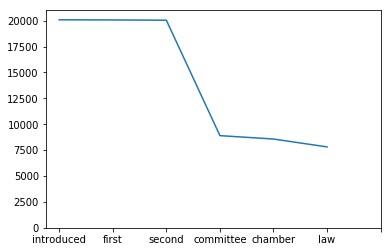

In [10]:
def search_actions(strings):
    """Search actions meeting one of a list of patterns. Strings passed as a list
     are concatenated and used as a regex.

    Returns a DataFrame with bills passing stage specified by string.
    """
    pattern = '|'.join(strings)

    return actions[actions.action.str.contains(pattern)] \
        .loc[:, ['session', 'bill_id']] \
        .drop_duplicates()


intro = search_actions(['Filed for introduction', 'Filed for intro.']) \
    .assign(introduced=1)

first = search_actions(['Passed on First Consideration', 'P1C']) \
    .assign(first=1)

second = search_actions(['Passed on Second Consideration', 'P2C']) \
    .assign(second=1)

committee = search_actions(['H. Placed on Regular Calendar', 'H. Placed on Consent Calendar',
                            'Placed on Senate Consent Calendar', 'Placed on Senate Regular Calendar']) \
    .assign(committee=1)

chamber = search_actions(['Passed H.', 'Passed Senate', 'Passed S.']) \
    .assign(chamber=1)

law = search_actions(['Signed by Governor', 'Returned by Governor without signature']) \
    .assign(law=1)

bills = bills \
    .merge(intro, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(first, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(second, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(committee, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(chamber, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(law, how='left', on=['session', 'bill_id'], validate='1:1')

bills[['introduced', 'first', 'second', 'committee', 'chamber', 'law']] \
    .sum(axis=0) \
    .plot(xticks=range(7), ylim=(0, 21000))

Note that companion bills are often introduced in both the House and Senate, so these counts overcount by about 2x.

The big gatekeeper is getting past committees; most bills don't get past committee, but once they do, they stand a good chance of passing. I'll want to predict which bills get past committee.

What do vote margins look like once bills get past committee?

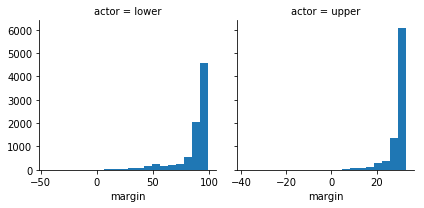

In [11]:
actions['ayes'] = pd.to_numeric(actions['action'].str.extract('Ayes ([0-9]+)', expand=False))
actions['nays'] = pd.to_numeric(actions['action'].str.extract('Nays ([0-9]+)', expand=False))

margin = actions.query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine = 'python') \
    .assign(margin=actions['ayes'] - actions['nays'])

g = sns.FacetGrid(margin, col='actor', sharex=False)
g = g.map(plt.hist, 'margin', bins=20)

Once past committee, many bills are uncontroversial (pass by an all-0 vote). I'll also identify uncontroversial bills so that we can de-prioritize those.

In [12]:
actions['uncontroversial'] = pd.Series(actions['nays'] <= 1).astype(int)

uncontroversial = actions \
    .query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine = 'python') \
    .query('actor == "upper" & bill_id.str.contains("SB") | actor == "lower" & bill_id.str.contains("HB")', engine = 'python') \
    .groupby(['session', 'bill_id']) \
    .agg({'uncontroversial': 'min'}) \
    .reset_index(drop=False)

bills = bills.merge(uncontroversial, how='left', on=['session', 'bill_id'], validate='1:1')

Of course, we know what happens to bills retrospectively. However, it would be helpful to know whether bills will go to a vote and/or be uncontroversial as they are introduced so that one might be able to influence legislation through calling one's legislators, etc. 

I use **machine learning** to predict these outcomes. The idea is to information about what bills have gone to a vote/been uncontroversial in the past to predict which bills will go to a vote/be uncontroversial in the future.

I use spaCy to do some preprocessing (drop stop words, lemmatize, and keep only certain parts of speech). I then use a TF-IDF representation and regularized logistic regression for classification.

In [13]:
import spacy
from nltk.corpus import stopwords

# Use spaCy annotator and convert to data frame with one token per row
nlp = spacy.load('en_core_web_sm')

tokens = []

for doc in nlp.pipe(bills['title'], batch_size=50):
    tokens.append([(n.text, n.lemma_, n.pos_) for n in doc])

# Convert tokens and entities to DataFrames and combine
annotation_df = pd.concat(
    [pd.DataFrame(tokens[i], columns=['token', 'lemma', 'pos']).assign(bill=i) 
	 for i in range(len(tokens))]
) \
    .reset_index()

In [14]:
# Drop and modify tokens depending of part of speech
# https://spacy.io/api/annotation#pos-tagging
annotation_df = annotation_df[annotation_df['pos'].isin(['NOUN', 'VERB', 'PROPN'])]

# Drop anything with nonword characters
annotation_df = annotation_df[~annotation_df['token'].str.contains('\\W|[0-9]')]

# Drop stopwords
annotation_df = annotation_df[~annotation_df['token'].isin(stopwords.words('english'))]

preprocess = pd.Series(
    [' '.join(annotation_df[annotation_df['bill'] == i]['lemma']) for i in range(len(bills))]
)

Add search terms of interest (should resolve differences in inflection):

In [15]:
from nltk.stem import WordNetLemmatizer

my_terms = ['test', 'assessment', 'TNReady', 'priority', 'ASD']
my_terms = [WordNetLemmatizer().lemmatize(i) for i in my_terms]

bills['my_terms'] = [int(max([j in annotation_df[annotation_df['bill'] == i]['lemma'].values for j in my_terms]))
					 for i in range(len(bills))]

In [16]:
# A TF-IDF representation
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(min_df=10, ngram_range=(1, 3))

X_tfidf = tf.fit_transform(preprocess)

To mimic prediction, I use the most recent session as test set and all prior as training:

In [17]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

In [18]:
train_count = sum(bills['session'] != 110)

X_train = X_tfidf[:train_count]
X_test = X_tfidf[train_count:]

bills['committee'].fillna(0, inplace=True)
Y_train_vote = bills['committee'][:train_count]
Y_test_vote = bills['committee'][train_count:]

bills['uncontroversial'].fillna(0, inplace=True)
Y_train_uncontroversial = bills['uncontroversial'][:train_count]
Y_test_uncontroversial = bills['uncontroversial'][train_count:]

I train a model to identify bills which go to a vote, predict on the test set, then check accuracy:

In [19]:
max(bills['committee'].mean(), 1 - bills['committee'].mean())

0.5569216984419334

In [20]:
# Elastic Net
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'l1_ratio': np.arange(0, 1, 0.2)
}

elastic_net = GridSearchCV(SGDClassifier(loss='log', max_iter=1000, tol=1e-6), params, cv=5)

elastic_net_vote = elastic_net.fit(X_train, Y_train_vote)

# Save predictions for later
predict_vote = elastic_net_vote.predict(X_test).astype(int)

accuracy_score(predict_vote, Y_test_vote)

0.923792160437557

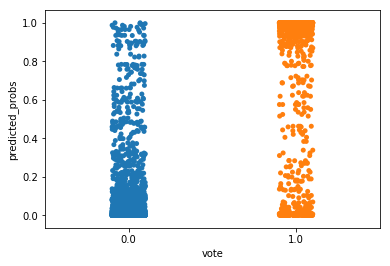

In [21]:
data = pd.DataFrame({
    'vote': Y_test_vote,
    'predicted_probs': elastic_net_vote.predict_proba(X_test)[:, 1]
})

sns.stripplot(x='vote', y='predicted_probs', data=data, jitter=True)

Repeat to predict uncontroversial bills:

In [22]:
max(bills['uncontroversial'].mean(), 1 - bills['uncontroversial'].mean())

0.6591667081487381

In [23]:
# Predict uncontroversial
elastic_net_uncontroversial = elastic_net.fit(X_train, Y_train_uncontroversial)

# Save predictions for later
predict_uncontroversial = elastic_net_uncontroversial.predict(X_test).astype(int)

accuracy_score(predict_uncontroversial, Y_test_uncontroversial)

0.9097538742023701

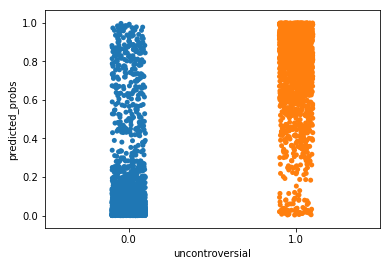

In [24]:
data = pd.DataFrame({
    'uncontroversial': Y_test_uncontroversial,
    'predicted_probs': elastic_net_uncontroversial.predict_proba(X_test)[:, 1]
})

sns.stripplot(x='uncontroversial', y='predicted_probs', data=data, jitter=True)

Check that we get some bills predicted to get a vote but not be uncontroversial:

In [25]:
sum(predict_vote != predict_uncontroversial)

465

In [26]:
# Predictions
prediction_set = bills[bills['session'] == 110] \
    .assign(
        predict_marginal=((predict_vote == 1) & (predict_uncontroversial == 0)).astype(int)
    ) \
    .loc[:, ['title', 'my_legislators', 'my_city_county', 'my_subjects', 'my_terms', 'predict_marginal']]

# Sort results by descending order of the number of categories matched
prediction_set['counts'] = prediction_set['my_city_county'] +\
						   prediction_set['my_legislators'] + \ 
						   prediction_set['my_subjects'] + \
						   prediction_set['my_terms'] + \
						   prediction_set['predict_marginal']

An answer to "What legislation should I pay attention to?" might look like the following:

In [27]:
prediction_set \
    .query('my_city_county == 1 | my_legislators == 1 | my_subjects == 1 | my_terms == 1 | predict_marginal == 1') \
    .sort_values(by='counts', ascending=False) \
    .head(10)

,title,my_legislators,my_city_county,my_subjects,my_terms,predict_marginal,counts
15215,"Teachers, Principals and School Personnel - As enacted, exempts certain supervisors, principals, and public school teachers from having to take an assessment to advance or renew a teaching license under certain circumstances.",0,0,1,1,1,3
19800,"Alcoholic Beverages - As enacted, designates Fresh Hospitality located in Nashville as an urban park center for purposes of consumption on the premises.",1,1,0,0,1,3
18329,"Local Education Agencies - As enacted, revises provisions governing the percentage of student achievement test scores comprising a student's final grade in certain subjects; revises provisions governing situations where certain test scores are not received at least five instructional days before the end of a course.",0,0,1,1,1,3
18100,"Local Education Agencies - As enacted, allows any LEA, rather than just the Metropolitan Nashville public school system, using the career academy or small learning community model to extend career and technical education (CTE) class sizes in grades nine through 12; allows an LEA to seek a waiver from the commissioner of education to extend the CTE class size average in grades nine through 12.",0,1,1,0,1,3
18226,"Teachers, Principals and School Personnel - As enacted, exempts certain supervisors, principals, and public school teachers from having to take an assessment to advance or renew a teaching license under certain circumstances.",0,0,1,1,1,3
15282,"Education, Curriculum - As introduced, beginning in the 2018-2019 school year and thereafter, prohibits the administration of end-of-course examinations to students in grades 9 through 12 and establishes the ACT as the only assessment that may be required for graduation.",0,0,1,1,1,3
16965,"Education - As enacted, requires local education agencies to use at least one alternative growth model that has been approved by the board of education for evaluation of teachers in non-tested grades and subjects; requires the department of education to develop alternative student growth models for grade levels and subjects that do not have growth models.",0,0,1,1,1,3
19082,"Education, Curriculum - As introduced, beginning in the 2018-2019 school year and thereafter, prohibits the administration of end-of-course examinations to students in grades 9 through 12 and establishes the ACT as the only assessment that may be required for graduation.",0,0,1,1,1,3
15199,"Local Education Agencies - As enacted, revises provisions governing the percentage of student achievement test scores comprising a student's final grade in certain subjects; revises provisions governing situations where certain test scores are not received at least five instructional days before the end of a course.",0,0,1,1,1,3
18999,"Education - As enacted, requires local education agencies to use at least one alternative growth model that has been approved by the board of education for evaluation of teachers in non-tested grades and subjects; requires the department of education to develop alternative student growth models for grade levels and subjects that do not have growth models.",0,0,1,1,1,3
